In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
# Carregar dataset
df_salario = pd.read_csv('./dataset/salario.csv')

In [32]:
# Inspecionar a estrutura do dataframe
df_salario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [33]:
# Copia para analise
df_salario_eda = df_salario.copy()
df_salario_bucketing = df_salario.copy()

## EDA

In [34]:
# Detectar valores ausentes
df_salario_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [35]:
# Medidas estatisticas
df_salario_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: xlabel='tempo_na_empresa'>

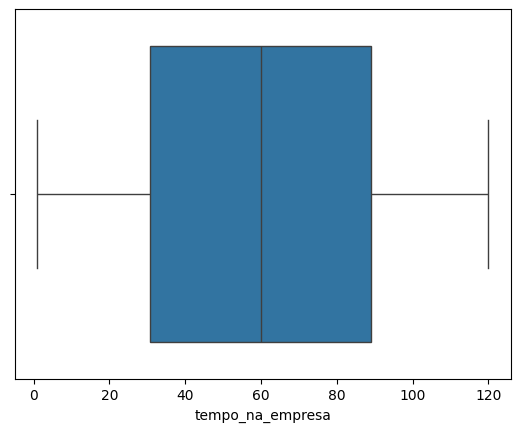

In [36]:
# Verificar / detectar outliers
sns.boxplot(data=df_salario_eda, x='tempo_na_empresa')

<Axes: xlabel='nivel_na_empresa'>

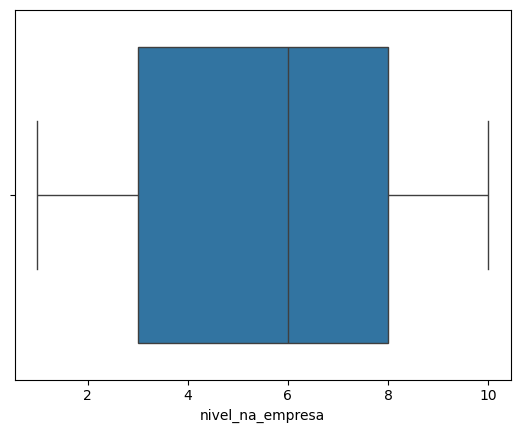

In [37]:
sns.boxplot(data=df_salario_eda, x='nivel_na_empresa')

<Axes: xlabel='salario_em_reais'>

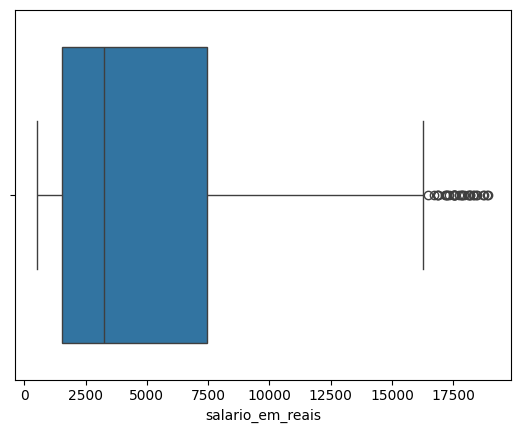

In [38]:
sns.boxplot(data=df_salario_eda, x='salario_em_reais')

<Axes: xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

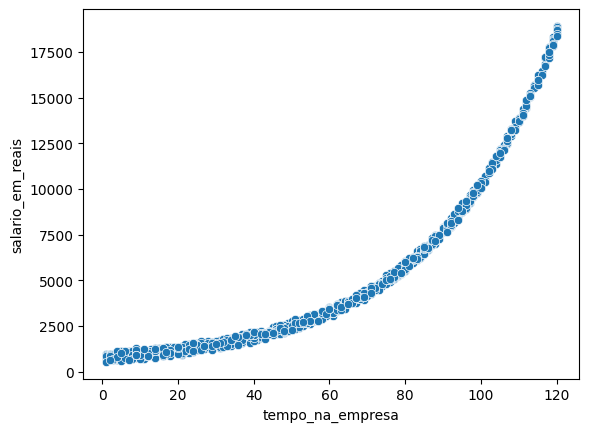

In [39]:
# Cruzamento variaveis numericas com salario em reais
sns.scatterplot(data=df_salario_eda, x='tempo_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

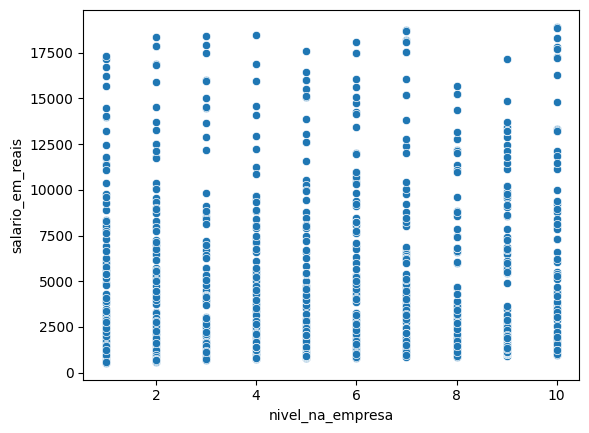

In [40]:
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='salario_em_reais')


<Axes: xlabel='nivel_na_empresa', ylabel='tempo_na_empresa'>

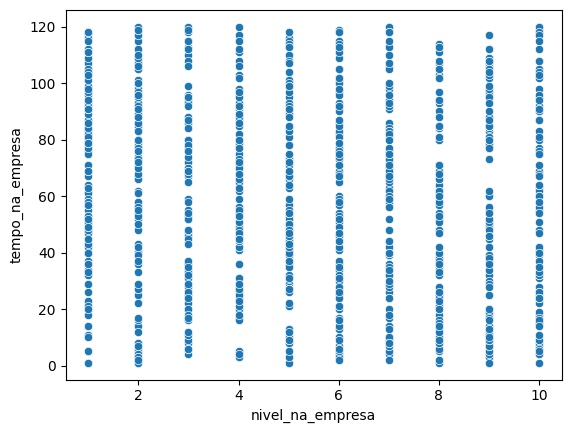

In [41]:
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='tempo_na_empresa')

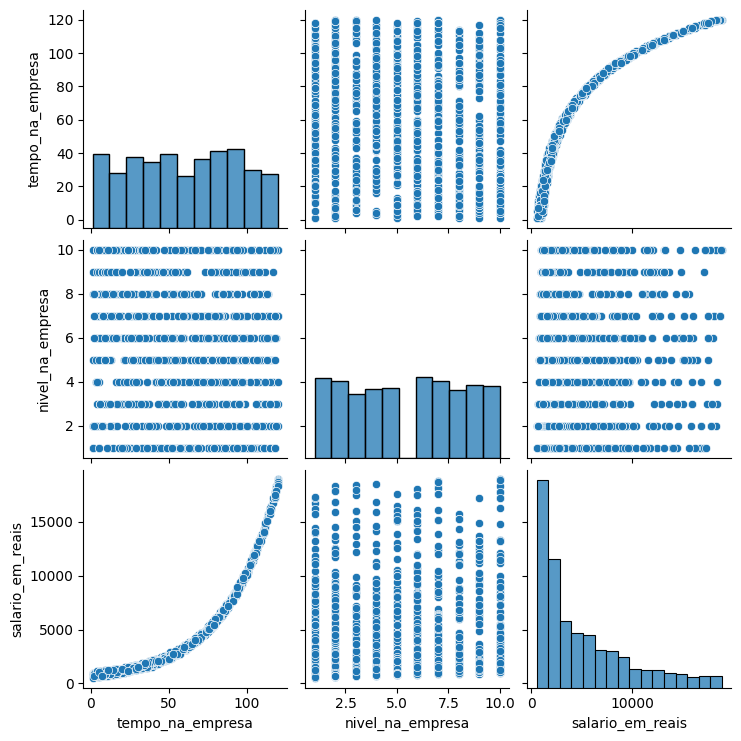

In [42]:
# Histogramas das variaveis
sns.pairplot(df_salario_eda)

<Axes: >

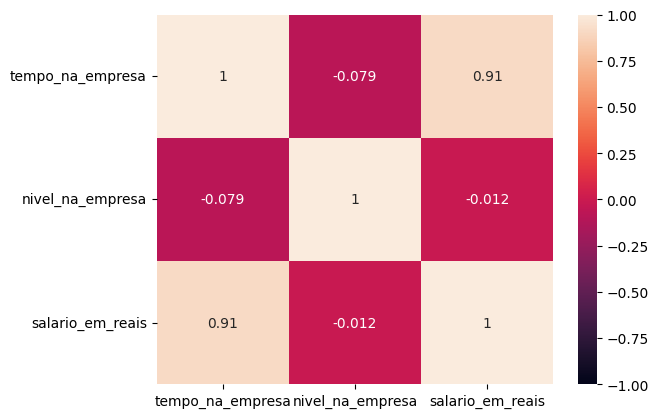

In [43]:
# Mapa de calor
sns.heatmap(df_salario_eda.corr(), vmin=-1, vmax=1, annot=True)

<Axes: >

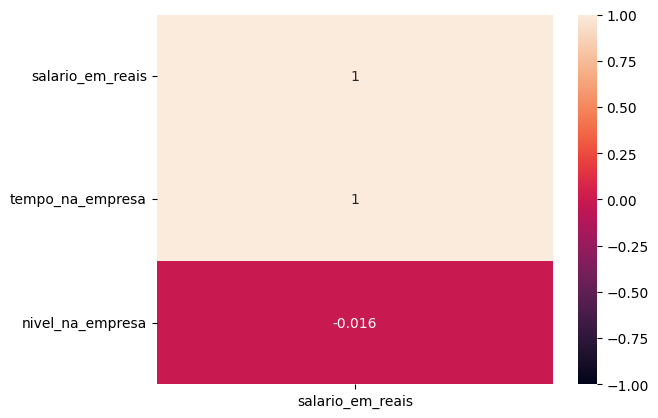

In [44]:
sns.heatmap(df_salario_eda.corr('spearman')[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), vmin=-1, vmax=1, annot=True)

In [45]:
# Bucketing tempo de casa
bins_tempo = [0, 10, 20, 30 ,40 ,50, 60, 70, 80, 90, 100, 110, 120, 130]
labels_tempo_casa = ['0-9', '10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','100-109','110-119', '120-129']
df_salario_bucketing['escala_tempo'] = pd.cut(x=df_salario_bucketing['tempo_na_empresa'], bins=bins_tempo, labels=labels_tempo_casa, include_lowest=True)

<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

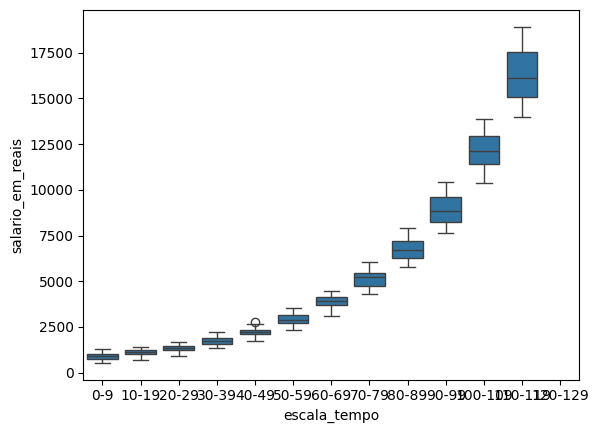

In [46]:
sns.boxplot(df_salario_bucketing, x='escala_tempo', y='salario_em_reais')

### Treinar modelo linear

In [47]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error

import numpy as np

In [48]:
# Criar dataset de treino e teste
X = df_salario.drop(columns='salario_em_reais', axis=1)
y = df_salario['salario_em_reais']

In [49]:
# Split usando KFold com 5 pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [52]:
# Bloco para treinamento do modelo
# Pipeline

colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

# Transformar colunas numericas
transformer_numericas = Pipeline(
  steps=[
    ('scaler', StandardScaler())
  ]
)

# Criar um Column Transformer
preprocessor = ColumnTransformer(transformers=[('num', transformer_numericas, colunas_numericas)])

# Criar Pipeline principal = Pre-processamento + Treinamento
model_regr = Pipeline(
  steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
  ]
)

# Armazenar RMSE de Treino e Teste
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar R2 Score de Teste
r2score_fold_test = []

# Armazenar Residuos
residuos = []

# Armazenar as predicoes
y_pred_total = []

for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  
  # Treinar modelo
  model_regr.fit(X_train, y_train)
  
  # Realizar predicoes nos conjuntos de treinamento e teste
  y_train_pred = model_regr.predict(X_train)
  y_test_pred = model_regr.predict(X_test)
  
  # Calcular RMSE, R2 Score e residuos para os conjuntos de treinamento e teste
  rmse_train = root_mean_squared_error(y_train, y_train_pred)
  rmse_test = root_mean_squared_error(y_test, y_test_pred)
  
  # Calcular R2 Score e residuos para os conjuntos de teste
  r2score_test = r2_score(y_test, y_test_pred)
  residuos_test = np.array(y_test - y_test_pred)
  
  # Armazenar metricas nas variaveis
  rmse_scores_fold_train.append(rmse_train)
  rmse_scores_fold_test.append(rmse_test)
  r2score_fold_test.append(r2score_test)
  residuos.append(residuos_test)
  y_pred_total.append(y_test_pred)
  
rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2score_test_final = np.mean(r2score_fold_test)
percentual_rmse_final = (rmse_test_final - rmse_train_final) / rmse_train_final * 100
residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)

### Analise de Metricas - Modelo Linear

In [53]:
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'Direfenca % RMSE Treino e Teste: {percentual_rmse_final}')
print(f'R2 Score Teste: {r2score_test_final}')

RMSE Treino: 1882.8318426651392
RMSE Teste: 1886.4504221336076
Direfenca % RMSE Treino e Teste: 0.19218813844503052
R2 Score Teste: 0.8261178870584761


### Analise de Residuos - Modelo Linear

In [55]:
# Transformar residuos na escala padrao
# Escala padrao - (X - media) / desvio_padrao
from scipy.stats import zscore

residuos_std = zscore(residuos)

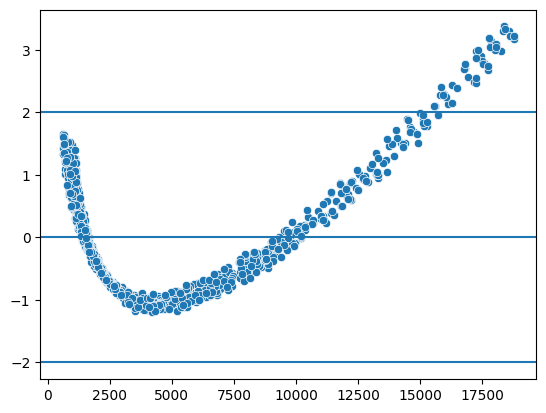

In [78]:
# Verificar linearidade dos residuos: Valores entre -2 e 2 (Escala padrao)
# Verificar Homocedasticidade: Valolres em torno da reta sem nenhuma tendencia ou formato
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

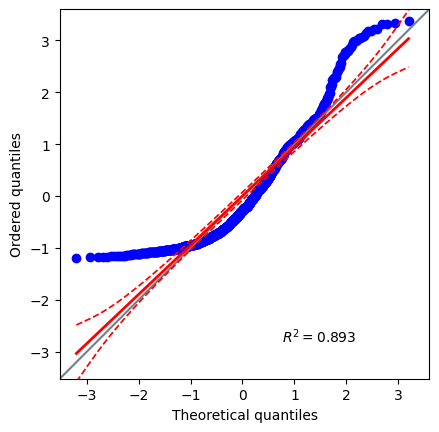

In [57]:
# Checar se residuos seguem uma distribuicao normal
# QQ Plot
import pingouin as pg

pg.qqplot(residuos_std, dist='norm', confidence=0.95)

In [58]:
# Teste de normalidade - Shapiro-Wilk
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

In [59]:
# Teste de Shapiro-Wilk
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estatistica do teste: {stat_shapiro} e p-value: {p_value_shapiro}')

Estatistica do teste: 0.891969217965228 e p-value: 7.013497918013492e-26


In [60]:
# Teste de Kolmoforov-Smirnov
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estatistica do teste: {stat_ks} e p-value: {p_value_ks}')

Estatistica do teste: 0.5939999999999955 e p-value: 0.0


In [61]:
# Teste de Lilliefors
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estatistica do teste: {stat_ll} e p-value: {p_value_ll}')

Estatistica do teste: 0.11825983774680088 e p-value: 0.0009999999999998899


### Treinar Modelo Polinomial

In [62]:
# Exemplo de criacao de features polinomiais
feat_poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = feat_poly.fit_transform(X)
feat_poly.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [63]:
# Apos o fit_transform 
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [76]:
# Bloco para treinamento do modelo

# graus_polynomial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
graus_polynomial = [4]

rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

# Split usando KFold com 5 pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynomial:
  # Pipeline
  colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

  # Transformar colunas numericas
  transformer_numericas = Pipeline(
    steps=[
      ('scaler', StandardScaler())
    ]
  )
  
  # Criar um Column Transformer
  preprocessor = ColumnTransformer(transformers=[('num', transformer_numericas, colunas_numericas)])

  # Criar features polinomiais
  poly_feat = PolynomialFeatures(degree=grau, include_bias=False)
  
  # Criar Pipeline principal = Pre-processamento + Treinamento
  model_poly = Pipeline(
    steps=[
      ('preprocessor', preprocessor),
      ('poly_features', poly_feat),
      ('regressor', LinearRegression())
    ]
  )

  # Armazenar RMSE de Treino e Teste
  rmse_scores_fold_train = []
  rmse_scores_fold_test = []

  # Armazenar R2 Score de Teste
  r2score_fold_test = []

  # Armazenar Residuos
  residuos = []

  # Armazenar as predicoes
  y_pred_total = []

  for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Treinar modelo
    model_poly.fit(X_train, y_train)
    
    # Realizar predicoes nos conjuntos de treinamento e teste
    y_train_pred = model_poly.predict(X_train)
    y_test_pred = model_poly.predict(X_test)
    
    # Calcular RMSE, R2 Score e residuos para os conjuntos de treinamento e teste
    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)
    
    # Calcular R2 Score e residuos para os conjuntos de teste
    r2score_test = r2_score(y_test, y_test_pred)
    residuos_test = np.array(y_test - y_test_pred)
    
    # Armazenar metricas nas variaveis
    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_test.append(rmse_test)
    r2score_fold_test.append(r2score_test)
    residuos.append(residuos_test)
    y_pred_total.append(y_test_pred)
    
  rmse_train_final = np.mean(rmse_scores_fold_train)
  rmse_test_final = np.mean(rmse_scores_fold_test)
  r2score_test_final = np.mean(r2score_fold_test)
  percentual_rmse_final = (rmse_test_final - rmse_train_final) / rmse_train_final * 100
  residuos = np.array(residuos).reshape(-1)
  y_pred_total = np.array(y_pred_total).reshape(-1)
  
  rmse_train_values.append(rmse_train_final)
  rmse_test_values.append(rmse_test_final)
  r2score_test_values.append(r2score_test_final)
  percentual_rmse_values.append(percentual_rmse_final)
  

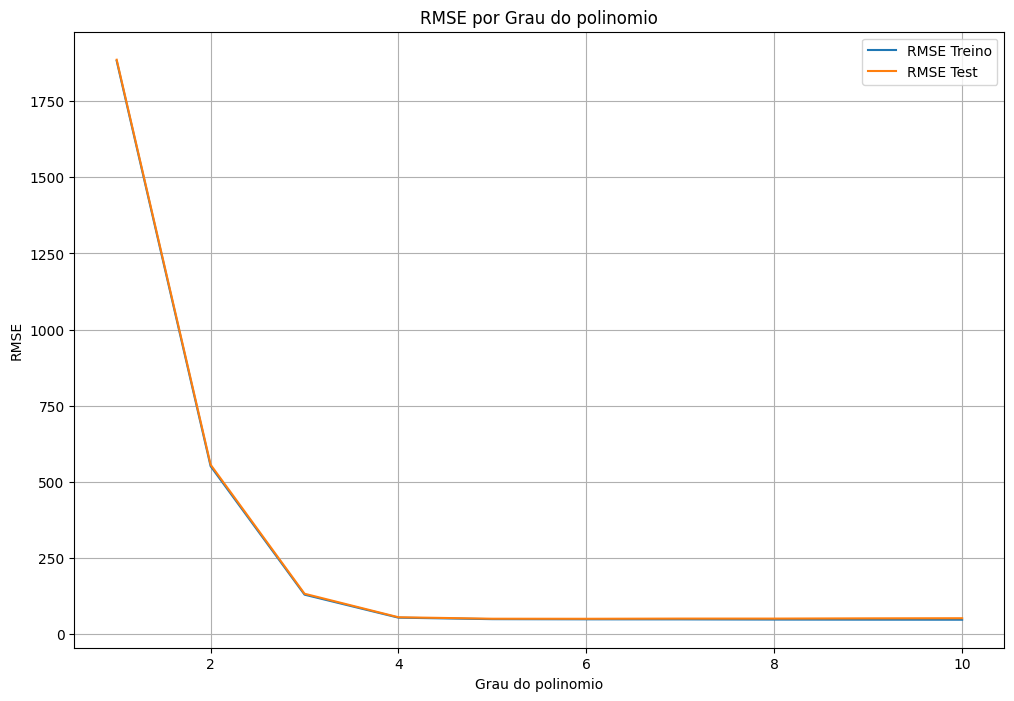

In [74]:
# Plotar grafico para comprar RMSE por grau de polinomio
plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, rmse_train_values, label='RMSE Treino')
plt.plot(graus_polynomial, rmse_test_values, label='RMSE Test')
plt.xlabel('Grau do polinomio')
plt.ylabel('RMSE')
plt.title('RMSE por Grau do polinomio')
plt.grid()
plt.legend()
plt.show()

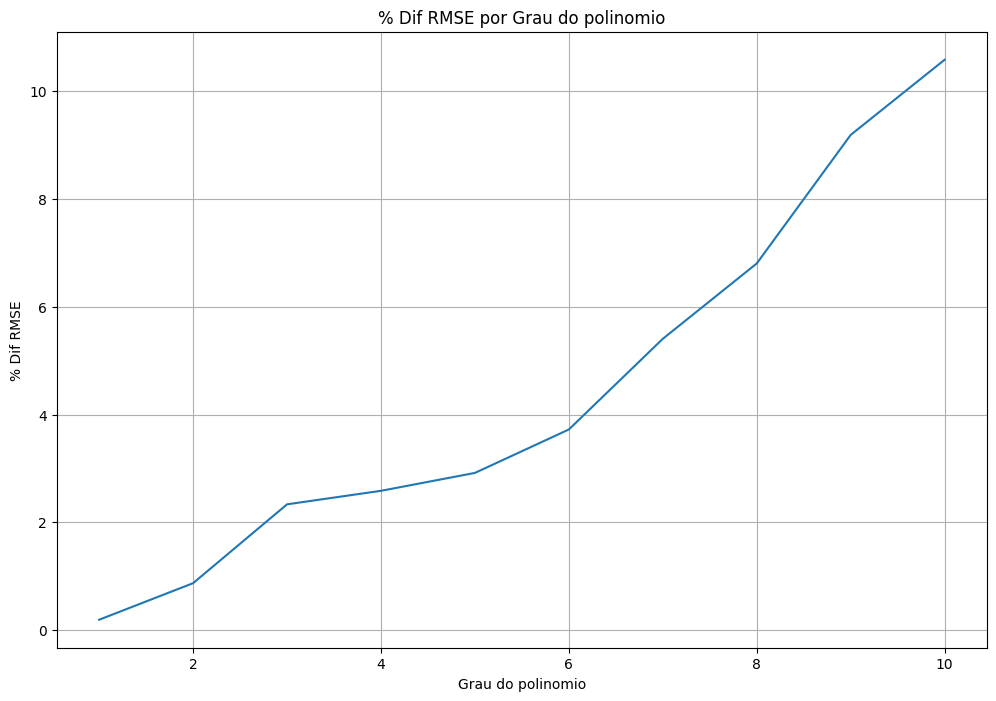

In [75]:
# Plotar grafico para comprar %Dif RMSE Treino e Teste
plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, percentual_rmse_values, label='%Dif RMSE Treino e Teste')
plt.xlabel('Grau do polinomio')
plt.ylabel('% Dif RMSE')
plt.title('% Dif RMSE por Grau do polinomio')
plt.grid()
plt.show()

### Analise de metricas - Modelo Polinomial

In [77]:
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'Direfenca % RMSE Treino e Teste: {percentual_rmse_final}')
print(f'R2 Score Teste: {r2score_test_final}')

RMSE Treino: 53.32698559565161
RMSE Teste: 54.70504352796304
Direfenca % RMSE Treino e Teste: 2.5841661907546576
R2 Score Teste: 0.9998524123039415


### Analise de Residuos - Modelo Polinomial

In [79]:
# Transformar residuos na escala padrao
# Escala padrao - (X - media) / desvio_padrao
from scipy.stats import zscore

residuos_std = zscore(residuos)

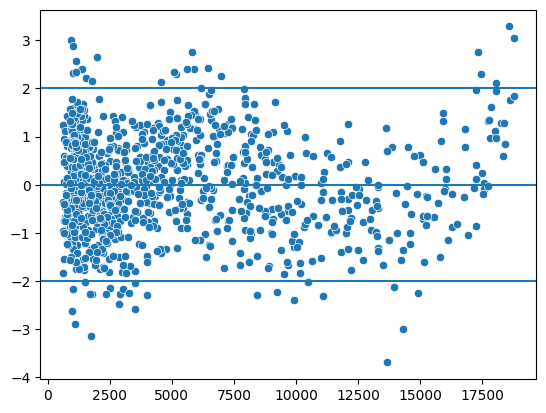

In [80]:
# Verificar linearidade dos residuos: Valores entre -2 e 2 (Escala padrao)
# Verificar Homocedasticidade: Valolres em torno da reta sem nenhuma tendencia ou formato
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)

plt.axhline(y=2)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

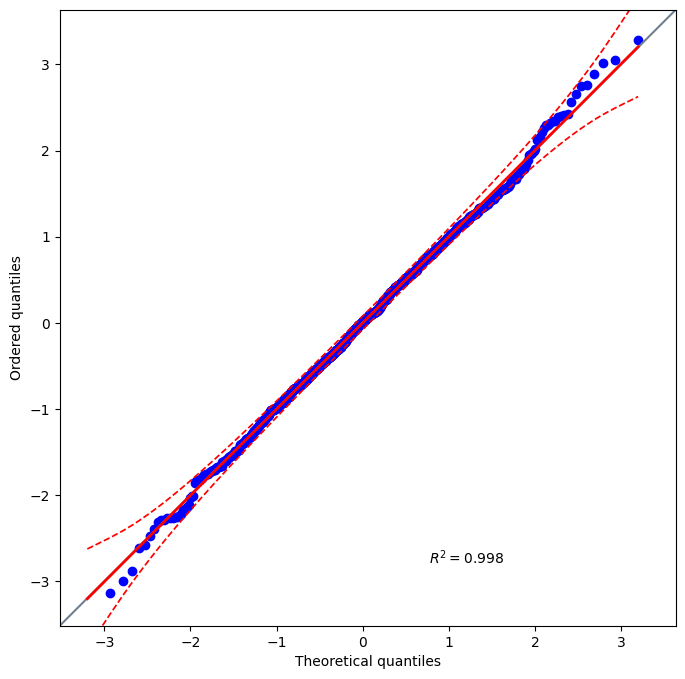

In [82]:
plt.figure(figsize=(12,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)

In [83]:
# Teste de Shapiro-Wilk
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estatistica do teste: {stat_shapiro} e p-value: {p_value_shapiro}')

Estatistica do teste: 0.9986951372205322 e p-value: 0.6852797159659514


In [84]:
# Teste de Kolmoforov-Smirnov
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estatistica do teste: {stat_ks} e p-value: {p_value_ks}')

Estatistica do teste: 0.48237446499530856 e p-value: 1.2202460106524514e-214


In [85]:
# Teste de Lilliefors
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estatistica do teste: {stat_ll} e p-value: {p_value_ll}')

Estatistica do teste: 0.013637346894986191 e p-value: 0.9566270022044506


## Realizar Predicoes Individuais

In [86]:
predicao_individual = {
  'tempo_na_empresa': 72,
  'nivel_na_empresa': 10
}

pred_df = pd.DataFrame(predicao_individual, index=[1])

In [87]:
# Predicao
model_poly.predict(pred_df)

array([4808.03154228])

In [88]:
import joblib

joblib.dump(model_poly, './modelo_salario.pkl')

['./modelo_salario.pkl']